---

# Setup

##### Set Root Dir as CWD

In [1]:
import os

# Navigate to project root (if not already there)
if os.path.split(os.getcwd())[1] != "cs374-project":
    %cd ../

D:\Documents\A_DIGIPEN\PersonalSVN\Fall22SVN\CS374\Project\cs374-project


##### Imports

In [56]:
import pickle

import numpy as np
import pandas as pd

import spacy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Local
from src.preprocesser import ReviewPreprocessor
from src.model import ReviewClassifier

# Load

In [3]:
path = "data/yelp/reviews/"

In [4]:
%%time
# Load dev set (10% of total data) as train
train = pd.read_pickle(path + "train.xz")

CPU times: total: 28.8 s
Wall time: 29.1 s


In [5]:
%%time
# Load test set (10% of total data) as test
test = pd.read_pickle(path + "test.xz")

CPU times: total: 3.58 s
Wall time: 3.58 s


In [6]:
train

,text,stars
2903612,I like Wedding Belles for an odd reason. I set...,5
5050964,We had a great stay here. I felt like we got a...,5
1226557,"A unique place for sure, not your standard bre...",3
776083,This will be a short review on service and gri...,4
227582,Great barbershop. Super friendly staff. They a...,5
...,...,...
3578067,I've not personally had the bad experiences th...,4
424533,Dive bar.\nNew ownership has improved the menu...,3
28275,"This place is so addicting, good vegan options...",5
2949771,"What is not to love about Wingfield Park, down...",5


##### Save Target

In [7]:
# Save reviews stars from 0-4
y_train = tf.convert_to_tensor(train["stars"].values - 1)
y_test = tf.convert_to_tensor(test["stars"].values - 1)

# Preprocess

In [10]:
batch_size = 4000
n_processes = 4

maxlen = 200         # Number of words per review to consider
vocab_size = 20_000  # Size of vocabulary

prep_path = f"experiments/preprocessors/final.pickle"

##### Load from raw data

> Preprocess from scratch. Takes a long time!

In [12]:
%%time
# Configure preprocessor based on comparison
prep = ReviewPreprocessor(vocab_size, maxlen, remove_stop=False, remove_punc=False, lemmatize=False)

# Preprocess text
X_train_norm = prep.normalize(train["text"], batch_size, n_processes)
X_test_norm = prep.normalize(test["text"], batch_size, n_processes)

# Fit tokenizer
prep.fit_tokenizer(X_train_norm)

# Convert to tensor of padded sequences
X_train = prep.to_tensor(X_train_norm)
X_test = prep.to_tensor(X_test_norm)

CPU times: total: 1h 23min 24s
Wall time: 3h 10min 1s


In [13]:
%%time
# Save results
pd.Series(X_train_norm).to_pickle(path + "train_prep.xz")
pd.Series(X_test_norm).to_pickle(path + "test_prep.xz")
prep.save_as_pickle(prep_path)

CPU times: total: 49min 21s
Wall time: 51min 20s


##### Load already preprocessed data

> Load already preprocessed data. Takes a bit.

In [11]:
%%time
# Load preprocessed
X_train_norm = pd.read_pickle(path + "train_prep.xz")
X_test_norm = pd.read_pickle(path + "test_prep.xz")

# Load preprocessor
prep = ReviewPreprocessor.load_from_pickle(prep_path)

# Convert to tensor of padded sequences
X_train = prep.to_tensor(X_train_norm)
X_test = prep.to_tensor(X_test_norm)

CPU times: total: 9min 22s
Wall time: 11min 48s


---

##### View Before and After Preprocessing

In [12]:
print_idx = 8
print(test["text"].iloc[print_idx])
print("\n - - - - \n")
print(X_test_norm[print_idx], len(X_test_norm[print_idx]))
print("\n - - - - \n")
print(X_test[print_idx])

Ordered through grub hub, food came half an hour past the maximum delivery window. A simple breakfast order took 90 minutes to get to me, and the potatoes were half raw. Delivery timing may not have been the restaurant's fault, but the undercooked food was.

Delivery fee is actually $3.99, NOT $0 as posted on yelp

 - - - - 

['ordered', 'through', 'grub', 'hub', ',', 'food', 'came', 'TIME', 'TIME', 'TIME', 'past', 'the', 'maximum', 'delivery', 'window', '.', 'a', 'simple', 'breakfast', 'order', 'took', '90', 'e0', 'TIME', 'to', 'get', 'to', 'me', ',', 'and', 'the', 'potatoes', 'were', 'CARDINAL', 'raw', '.', 'delivery', 'timing', 'may', 'not', 'have', 'been', 'the', 'restaurant', "'", 's', 'fault', ',', 'but', 'the', 'undercooked', 'food', 'was', '.', 'delivery', 'fee', 'is', 'actually', '$', '3', 'e0', '.', '99', 'e0', ',', 'not', '$', '0', 'e0', 'as', 'posted', 'on', 'yelp'] 73

 - - - - 

tf.Tensor(
[ 104  290 3711 5009    4   38  115   23   23   23  783    2 7513  593
  900    1  

# Model

* Reference https://keras.io/examples/nlp/text_classification_with_transformer/

##### Create Model

In [13]:
# Hyperparameters
embed_dim = 32  # Attention output size
num_heads = 2   # Number of attention heads
ff_dims = [32]  # Hidden layer sizes in feed forward network inside transformer
reg = 1.0e-2    # L2 Reg based on comparison
dropout = 0.3   # Dropout based on comparison

# Model
model = ReviewClassifier(maxlen, vocab_size, embed_dim, num_heads, ff_dims, reg, dropout)

In [14]:
model.predict(X_train[:5])

1/1 [==============================] - 2s 2s/step


array([[0.15694028, 0.19558105, 0.1585571 , 0.24361321, 0.24530843],
       [0.1702983 , 0.21328758, 0.07838115, 0.31940526, 0.21862768],
       [0.14197375, 0.205456  , 0.03435435, 0.40518376, 0.21303208],
       [0.15400489, 0.18007413, 0.12180891, 0.27932695, 0.26478514],
       [0.14453752, 0.20823543, 0.03128969, 0.40455407, 0.21138325]],
      dtype=float32)

##### Compile and Run

In [15]:
learning_rate = 1e-3

model.compile(optimizer=keras.optimizers.Adam(learning_rate), 
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.build(X_train.shape)

In [16]:
model.summary()

Model: "review_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 t_emb (Embedding)           multiple                  640000    
                                                                 
 p_emb (Embedding)           multiple                  6400      
                                                                 
 attention (MultiHeadAttenti  multiple                 8416      
 on)                                                             
                                                                 
 sequential (Sequential)     (None, 200, 32)           1056      
                                                                 
 layer_normalization (LayerN  multiple                 64        
 ormalization)                                                   
                                                                 
 layer_normalization_1 (Laye  multiple           

In [17]:
%%time
# Train model
epochs = 10
cp_path = "experiments/model_checkpoints/"

# Early stopping 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

# Create a callback that saves the model's weights
checkpoint_dir = os.path.dirname(cp_path)
create_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=cp_path + f"final.ckpt", monitor="val_loss", verbose=1, save_best_only=True)

history = model.fit(
    X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test),
    callbacks=[early_stopping, create_checkpoint], verbose=1,
)

Epoch 1/10
174746/174757 [============================>.] - ETA: 0s - loss: 0.7670 - accuracy: 0.6843
Epoch 1: val_loss improved from inf to 0.72302, saving model to experiments/model_checkpoints\final.ckpt


INFO:tensorflow:Assets written to: experiments/model_checkpoints\final.ckpt\assets


INFO:tensorflow:Assets written to: experiments/model_checkpoints\final.ckpt\assets


174757/174757 [==============================] - 641s 4ms/step - loss: 0.7670 - accuracy: 0.6843 - val_loss: 0.7230 - val_accuracy: 0.6957
Epoch 2/10
174743/174757 [============================>.] - ETA: 0s - loss: 0.7379 - accuracy: 0.6952
Epoch 2: val_loss improved from 0.72302 to 0.71096, saving model to experiments/model_checkpoints\final.ckpt


INFO:tensorflow:Assets written to: experiments/model_checkpoints\final.ckpt\assets


INFO:tensorflow:Assets written to: experiments/model_checkpoints\final.ckpt\assets


174757/174757 [==============================] - 650s 4ms/step - loss: 0.7379 - accuracy: 0.6952 - val_loss: 0.7110 - val_accuracy: 0.7032
Epoch 3/10
174746/174757 [============================>.] - ETA: 0s - loss: 0.7291 - accuracy: 0.6990
Epoch 3: val_loss improved from 0.71096 to 0.70973, saving model to experiments/model_checkpoints\final.ckpt


INFO:tensorflow:Assets written to: experiments/model_checkpoints\final.ckpt\assets


INFO:tensorflow:Assets written to: experiments/model_checkpoints\final.ckpt\assets


174757/174757 [==============================] - 647s 4ms/step - loss: 0.7291 - accuracy: 0.6990 - val_loss: 0.7097 - val_accuracy: 0.7006
Epoch 4/10
174748/174757 [============================>.] - ETA: 0s - loss: 0.7238 - accuracy: 0.7013
Epoch 4: val_loss did not improve from 0.70973
174757/174757 [==============================] - 656s 4ms/step - loss: 0.7238 - accuracy: 0.7013 - val_loss: 0.7125 - val_accuracy: 0.7020
Epoch 5/10
174749/174757 [============================>.] - ETA: 0s - loss: 0.7201 - accuracy: 0.7028
Epoch 5: val_loss improved from 0.70973 to 0.70266, saving model to experiments/model_checkpoints\final.ckpt


INFO:tensorflow:Assets written to: experiments/model_checkpoints\final.ckpt\assets


INFO:tensorflow:Assets written to: experiments/model_checkpoints\final.ckpt\assets


174757/174757 [==============================] - 659s 4ms/step - loss: 0.7201 - accuracy: 0.7028 - val_loss: 0.7027 - val_accuracy: 0.7057
Epoch 6/10
174747/174757 [============================>.] - ETA: 0s - loss: 0.7175 - accuracy: 0.7038
Epoch 6: val_loss did not improve from 0.70266
174757/174757 [==============================] - 659s 4ms/step - loss: 0.7175 - accuracy: 0.7038 - val_loss: 0.7156 - val_accuracy: 0.6964
Epoch 7/10
174750/174757 [============================>.] - ETA: 0s - loss: 0.7159 - accuracy: 0.7047
Epoch 7: val_loss improved from 0.70266 to 0.70145, saving model to experiments/model_checkpoints\final.ckpt


INFO:tensorflow:Assets written to: experiments/model_checkpoints\final.ckpt\assets


INFO:tensorflow:Assets written to: experiments/model_checkpoints\final.ckpt\assets


174757/174757 [==============================] - 666s 4ms/step - loss: 0.7159 - accuracy: 0.7047 - val_loss: 0.7015 - val_accuracy: 0.7029
Epoch 8/10
174744/174757 [============================>.] - ETA: 0s - loss: 0.7148 - accuracy: 0.7050
Epoch 8: val_loss did not improve from 0.70145
174757/174757 [==============================] - 665s 4ms/step - loss: 0.7148 - accuracy: 0.7050 - val_loss: 0.7052 - val_accuracy: 0.7047
Epoch 9/10
174746/174757 [============================>.] - ETA: 0s - loss: 0.7141 - accuracy: 0.7054
Epoch 9: val_loss did not improve from 0.70145
174757/174757 [==============================] - 666s 4ms/step - loss: 0.7141 - accuracy: 0.7054 - val_loss: 0.7026 - val_accuracy: 0.7049
Epoch 10/10
174751/174757 [============================>.] - ETA: 0s - loss: 0.7136 - accuracy: 0.7054
Epoch 10: val_loss did not improve from 0.70145
174757/174757 [==============================] - 644s 4ms/step - loss: 0.7136 - accuracy: 0.7054 - val_loss: 0.7052 - val_accuracy: 0.

In [58]:
# Save history
with open('experiments/results/final_modelling_history.pickle', 'wb') as handle:
    pickle.dump(history.history, handle)

In [54]:
# Save model
model.save("experiments/models/final_model")

INFO:tensorflow:Assets written to: experiments/models/final_model\assets


INFO:tensorflow:Assets written to: experiments/models/final_model\assets


# Evaluate

In [59]:
# Load history
with open('experiments/results/final_modelling_history.pickle', 'rb') as handle:
    test = pickle.load(handle)

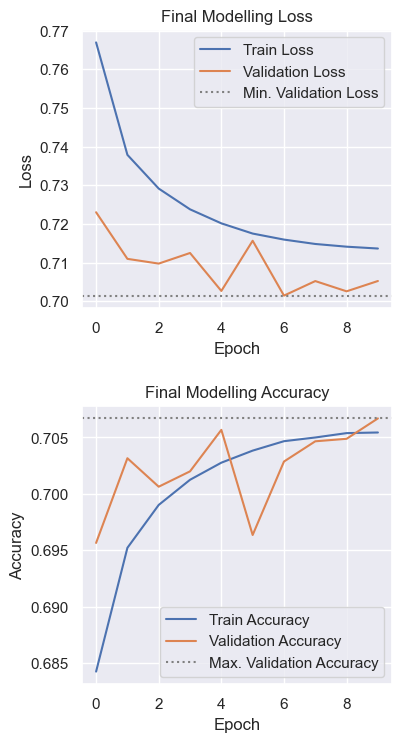

In [52]:
hist = history.history
loss, val_loss = hist["loss"], hist["val_loss"]
acc, val_acc = hist["accuracy"], hist["val_accuracy"]

fig, axes = plt.subplots(2, 1, figsize=(4, 8.5), dpi=100)

axes[0].plot(loss, label="Train Loss")
axes[0].plot(val_loss, label="Validation Loss")
axes[0].axhline(min(val_loss), linestyle=":", label="Min. Validation Loss", color="grey")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Final Modelling Loss")
axes[0].legend()

axes[1].plot(acc, label="Train Accuracy")
axes[1].plot(val_acc, label="Validation Accuracy")
axes[1].axhline(max(val_acc), linestyle=":", label="Max. Validation Accuracy", color="grey")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Final Modelling Accuracy")
axes[1].legend()

plt.subplots_adjust(hspace=0.35)

plt.show()

##### Evaluate

In [61]:
# Get probabilities per class
y_pred = model.predict(X_test)

21845/21845 [==============================] - 200s 9ms/step


In [62]:
# Get star predictions and negative/positive predictions
y_pred_multi = tf.argmax(y_pred, axis=1)

In [53]:
# Calculate continuous star rating based on probabilities
star_reg = tf.reduce_sum(y_pred * np.array([0, 1, 2, 3, 4]), axis=1)
star_reg

<tf.Tensor: shape=(699028,), dtype=float64, numpy=
array([3.91745288, 3.82218743, 0.09109641, ..., 3.96920484, 3.10105394,
       3.89718001])>

In [54]:
# Determine if sentiment is negative or postiive
y_pred_binary = star_reg > 2

In [55]:
print("multi-class accuracy: " + str((y_pred_multi == y_test).numpy().sum() / len(y_test)))
print("(compare to ~0.2)")

multi-class accuracy: 0.6949950502698032
(compare to ~0.2)


In [56]:
print("binary accuracy: " + str((y_pred_binary == (y_test >= 3)).numpy().sum() / len(y_test)))
print("(compare to ~0.5)")

binary accuracy: 0.9059236539881093
(compare to ~0.5)


In [57]:
avg_err = tf.reduce_sum(tf.math.abs(y_test - y_pred_multi)) / len(y_test)
avg_err = avg_err.numpy()
print(f"Average of {avg_err:.4f} stars off")

Average of 0.3809 stars off


##### Visualize Attention

In [58]:
# Get attention scores
_, attns = model(X_test[:100], return_att=True)

# Get attention for each sample
attns = tf.reduce_mean(attns, axis=2)[:, 0, :]
attns

<tf.Tensor: shape=(100, 200), dtype=float32, numpy=
array([[0.04983199, 0.        , 0.03516538, ..., 0.        , 0.        ,
        0.        ],
       [0.00950472, 0.20049529, 0.005     , ..., 0.        , 0.        ,
        0.        ],
       [0.07      , 0.27999842, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.025     , 0.08984116, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.005     , 0.03      , 0.07      , ..., 0.        , 0.        ,
        0.        ],
       [0.135     , 0.17285107, 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [59]:
attns[0][:34]

<tf.Tensor: shape=(34,), dtype=float32, numpy=
array([4.98319902e-02, 0.00000000e+00, 3.51653807e-02, 5.75425662e-02,
       1.99999996e-02, 1.98365208e-02, 3.50033864e-02, 0.00000000e+00,
       1.99999996e-02, 0.00000000e+00, 0.00000000e+00, 9.99999978e-03,
       0.00000000e+00, 0.00000000e+00, 4.99999989e-03, 0.00000000e+00,
       0.00000000e+00, 6.46237913e-06, 0.00000000e+00, 9.99999978e-03,
       6.28405600e-04, 0.00000000e+00, 3.43715958e-02, 0.00000000e+00,
       3.89999241e-01, 0.00000000e+00, 2.74574328e-02, 0.00000000e+00,
       9.99999978e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00017525e-02, 1.50034457e-01], dtype=float32)>

<Original Text>
This place is NOT closed.  We went there on 18 August 2017.  Great, great corned beef and pastrami sandwich, the Bains special.  Also wonderful Italian sub and tuna sandwich.  Our picky son, who eats nothing, actually ate a third of his sister's sandwich.  One of the best lunches we've had in a long time.  Really nice staff and not a bad price.

<Preprocessed>
['place', 'close', 'go', '18', 'e0', 'date', '20', 'e2', 'great', 'great', 'corned', 'beef', 'pastrami', 'sandwich', 'norp', 'special', 'wonderful', 'norp', 'sub', 'tuna', 'sandwich', 'picky', 'son', 'eat', 'actually', 'eat', 'ordinal', 'sister', "'", 's', 'sandwich', 'cardinal', 'good', 'lunch', "'", 've', 'long', 'time', 'nice', 'staff', 'bad', 'price']


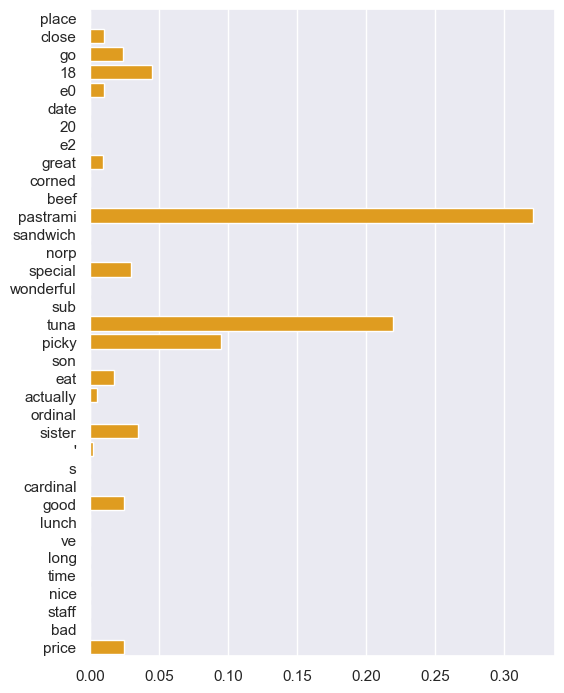

In [66]:
sample_idx = 6

# Get word sequences without oov words
in_seq = X_test_norm[sample_idx]
in_seq = [tok for tok in prep.tokenizer.sequences_to_texts(prep.tokenizer.texts_to_sequences(in_seq)) if tok]
seq_len = len(in_seq)

# Get attention values
attn_vals = attns[sample_idx][:seq_len].numpy()

print("<Original Text>")
print(test["text"].iloc[sample_idx])

print("\n<Preprocessed>")
print(in_seq)

plt.figure(figsize=(6, 0.2 * seq_len), dpi=100)
sns.barplot(y=in_seq, x=attn_vals, ci=None, color="orange")

plt.show()